### An example of MLP on MNIST data (numpy implementation)
Wei Li

In [5]:
import os
import sys

sys.path
# If running the .py script, uncomment the next line
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
# add parent directory: adds the parent directory of the module requiring it (__file__)
# to the beginning of the module search path.

# change the working directory to the parent folder
os.chdir("..")

import matplotlib.pyplot as plt
from utils import get_data_utils
from utils import data_processor
from models.mlp import *
from nn.modules.loss import *
from nn.modules.activation import *
from nn.modules.batchnorm import *
from nn.modules.linear import *
from nn.modules.dropout import *
from nn.modules.initializer import *
from optim.sgd import *
from optim.adam import *
from evaluation.multiclass_eval import *

import random

random_seed = 123
os.environ["PL_GLOBAL_SEED"] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [6]:
# %pip install watermark
%load_ext watermark
%watermark -a "Wei Li" -u -t -d -v -p numpy,torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Wei Li

Last updated: 2023-12-11 22:16:07

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

numpy: 1.21.5
torch: 1.12.1



In [7]:
##########################
### MNIST DATASET (Numpy data)
##########################

# obtain MNIST numpy files
dataset = get_data_utils.get_np_mnist(validation_fraction=0.2)
train_x = dataset[0]  # shape (size , 1, 28, 28)
train_y = dataset[1]  # shape (size , 1)
valid_x = dataset[2]
valid_y = dataset[3]
test_x = dataset[4]
test_y = dataset[5]

# do it as one-dim vector
train_x = train_x.reshape(-1, 28 * 28)
valid_x = valid_x.reshape(-1, 28 * 28)
test_x = test_x.reshape(-1, 28 * 28)

# process data targets
train_y = data_processor.to_onehot(train_y, 10)
valid_y = data_processor.to_onehot(valid_y, 10)
test_y = data_processor.to_onehot(test_y, 10)

train_x.dtype, train_x.shape  # (48000, 784)
train_y.dtype, train_y.shape  # (48000, 10)

# normalize data input (to -1 std, +1 std )
dat_norm = data_processor.input_normalizer()
train_x = dat_norm.fit_transform(train_x, method="grand")
# nomalize using grand mean and std obtained from training data already scaled on [0, 1]
dat_norm.mu  # 0.13086964
dat_norm.std  # 0.30839708

valid_x = dat_norm.transform(valid_x)
test_x = dat_norm.transform(test_x)

# train, validation, test data
train_data = [train_x, train_y]
valid_data = [valid_x, valid_y]
test_data = [test_x, test_y]

In [8]:
########################
##### model with BN   ##
########################

input_size = 28 * 28
output_size = 10
hiddens = [32, 32, 32]
activations = [Sigmoid(), Sigmoid(), Sigmoid(), Identity()]
# The last activation is the activation that produces output
# we use identity because the CrossEntropyLoss() we use here
# is taking logits

momentum = 0.85
lr = 1e-2
l2_weight = 0.1
criterion = CrossEntropyLoss()

# -----  Test case 1: one optimizer  ------

num_bn_layers = 3

model1 = MLP(
    input_size,
    output_size,
    hiddens,
    activations,
    weight_init_fn=weight_init_randn,
    bias_init_fn=bias_init,
    num_bn_layers=num_bn_layers,
)

model1.print_structure()
print_dict(model1.layers_dict)
print_keys(model1.paras_dict)

model_paras_list = model1.get_parameters()

optimizer = SgdDecay(model_paras_list, lr=lr, momentum=momentum, l2_weight=l2_weight)
optimizers = [optimizer]

num_epochs = 50
batch_size = 256

output = trainer_multiclass(
    model1,
    optimizers,
    criterion,
    train_data,
    valid_data,
    num_epochs,
    batch_size,
    print_all=False,
)

training_losses, training_errors, validation_losses, validation_errors = output


-----------------------
The model architecture:
layer0:
	sublayer0: <nn.modules.linear.Linear object at 0x13e131550>
	sublayer1: <nn.modules.batchnorm.BatchNorm1d object at 0x16e113ee0>
	sublayer2: <nn.modules.activation.Sigmoid object at 0x13e12b610>
layer1:
	sublayer0: <nn.modules.linear.Linear object at 0x103f9ebb0>
	sublayer1: <nn.modules.batchnorm.BatchNorm1d object at 0x13e131220>
	sublayer2: <nn.modules.activation.Sigmoid object at 0x16e113df0>
layer2:
	sublayer0: <nn.modules.linear.Linear object at 0x13e118f40>
	sublayer1: <nn.modules.batchnorm.BatchNorm1d object at 0x13e1313d0>
	sublayer2: <nn.modules.activation.Sigmoid object at 0x16e113cd0>
layer3:
	sublayer0: <nn.modules.linear.Linear object at 0x1040e5790>
	sublayer1: <nn.modules.activation.Identity object at 0x16e113e50>

---------------------------------
layers with learnable parameters:
layer0 
 (0)linear
(32, 784)
(32, 1)

layer0 
 (1)batchnorm
(1, 32)
(1, 32)

layer1 
 (0)linear
(32, 32)
(32, 1)

layer1 
 (1)batchnorm

In [9]:
# ------ Test case 2: separate optimizers  ---------

model2 = MLP(
    input_size,
    output_size,
    hiddens,
    activations,
    weight_init_fn=weight_init_randn,
    bias_init_fn=bias_init,
    num_bn_layers=num_bn_layers,
)

linear_paras_list = model2.get_parameters("linear")
bn_paras_list = model2.get_parameters("batchnorm")
optimizer_linear = SgdDecay(
    linear_paras_list, lr=lr, momentum=momentum, l2_weight=l2_weight
)
optimizer_bn = SgdDecay(bn_paras_list, lr=lr, momentum=0.0, l2_weight=0.0)
optimizers = [optimizer_linear, optimizer_bn]


num_epochs = 50
batch_size = 256

output = trainer_multiclass(
    model2,
    optimizers,
    criterion,
    train_data,
    valid_data,
    num_epochs,
    batch_size,
    print_all=False,
)

training_losses, training_errors, validation_losses, validation_errors = output


layer0 
 (0)linear
(32, 784)
(32, 1)

layer1 
 (0)linear
(32, 32)
(32, 1)

layer2 
 (0)linear
(32, 32)
(32, 1)

layer3 
 (0)linear
(10, 32)
(10, 1)

layer0 
 (1)batchnorm
(1, 32)
(1, 32)

layer1 
 (1)batchnorm
(1, 32)
(1, 32)

layer2 
 (1)batchnorm
(1, 32)
(1, 32)

Epoch: 001/050 | Train loss: 1.5809 | Validation loss: 1.4510 
Epoch: 001/050 | Train error: 0.4824 | Validation error: 0.3862 
Time elapsed: 0.13 min
Epoch: 002/050 | Train loss: 1.2875 | Validation loss: 1.2175 
Epoch: 002/050 | Train error: 0.2741 | Validation error: 0.1999 
Time elapsed: 0.13 min
Epoch: 003/050 | Train loss: 0.9909 | Validation loss: 0.9733 
Epoch: 003/050 | Train error: 0.1458 | Validation error: 0.1532 
Time elapsed: 0.12 min
Epoch: 004/050 | Train loss: 0.7810 | Validation loss: 0.7519 
Epoch: 004/050 | Train error: 0.0976 | Validation error: 0.0816 
Time elapsed: 0.15 min
Epoch: 005/050 | Train loss: 0.7048 | Validation loss: 0.6915 
Epoch: 005/050 | Train error: 0.0829 | Validation error: 0.0763 
Ti

In [10]:
#############################
#### model with Dropout  ####
#############################

# - ------- Test case 3 ------------

input_size = 28 * 28
output_size = 10
hiddens = [32, 32, 32]
activations = [Sigmoid(), Sigmoid(), Sigmoid(), Identity()]

momentum = 0.85
lr = 1e-1
l2_weight = 0.1
criterion = CrossEntropyLoss()

num_bn_layers = 0
drop_prob = 0.05

model3 = MLP(
    input_size,
    output_size,
    hiddens,
    activations,
    weight_init_fn=weight_init_randn,
    bias_init_fn=bias_init,
    num_bn_layers=num_bn_layers,
    drop_p=drop_prob,
)

model3.print_structure()
print_dict(model3.layers_dict)
print_keys(model3.paras_dict)


model_paras_list = model3.get_parameters()

optimizer = SgdDecay(model_paras_list, lr=lr, momentum=momentum)
optimizers = [optimizer]

num_epochs = 50
batch_size = 256

output = trainer_multiclass(
    model3,
    optimizers,
    criterion,
    train_data,
    valid_data,
    num_epochs,
    batch_size,
    print_all=False,
)

training_losses, training_errors, validation_losses, validation_errors = output


-----------------------
The model architecture:
layer0:
	sublayer0: <nn.modules.dropout.Dropout object at 0x13e118d00>
	sublayer1: <nn.modules.linear.Linear object at 0x16b8638e0>
	sublayer2: <nn.modules.activation.Sigmoid object at 0x16b8635b0>
layer1:
	sublayer0: <nn.modules.dropout.Dropout object at 0x13e118b50>
	sublayer1: <nn.modules.linear.Linear object at 0x103ef39d0>
	sublayer2: <nn.modules.activation.Sigmoid object at 0x16b863700>
layer2:
	sublayer0: <nn.modules.dropout.Dropout object at 0x16b863880>
	sublayer1: <nn.modules.linear.Linear object at 0x103f9e7c0>
	sublayer2: <nn.modules.activation.Sigmoid object at 0x16b863610>
layer3:
	sublayer0: <nn.modules.linear.Linear object at 0x13e118340>
	sublayer1: <nn.modules.activation.Identity object at 0x16b863760>

---------------------------------
layers with learnable parameters:
layer0 
 (1)linear
(32, 784)
(32, 1)

layer1 
 (1)linear
(32, 32)
(32, 1)

layer2 
 (1)linear
(32, 32)
(32, 1)

layer3 
 (0)linear
(10, 32)
(10, 1)

laye

In [11]:
################################
###### model with ADAM   #######
################################

# --------- Test case 4 --------------

input_size = 28 * 28
output_size = 10
hiddens = [32, 32, 32]
activations = [Sigmoid(), Sigmoid(), Sigmoid(), Identity()]

lr = 1e-2
criterion = CrossEntropyLoss()

num_bn_layers = 0

model4 = MLP(
    input_size,
    output_size,
    hiddens,
    activations,
    weight_init_fn=weight_init_randn,
    bias_init_fn=bias_init,
    num_bn_layers=num_bn_layers,
)

model_paras_list = model4.get_parameters()

optimizer = AdamW(model_paras_list, lr=lr, weight_decay=0.01)
optimizers = [optimizer]

num_epochs = 50
batch_size = 256

output = trainer_multiclass(
    model4,
    optimizers,
    criterion,
    train_data,
    valid_data,
    num_epochs,
    batch_size,
    print_all=False,
)

training_losses, training_errors, validation_losses, validation_errors = output


layer0 
 (0)linear
(32, 784)
(32, 1)

layer1 
 (0)linear
(32, 32)
(32, 1)

layer2 
 (0)linear
(32, 32)
(32, 1)

layer3 
 (0)linear
(10, 32)
(10, 1)

Epoch: 001/050 | Train loss: 1.2070 | Validation loss: 0.5304 
Epoch: 001/050 | Train error: 0.3421 | Validation error: 0.1573 
Time elapsed: 0.12 min
Epoch: 002/050 | Train loss: 0.4625 | Validation loss: 0.3761 
Epoch: 002/050 | Train error: 0.1405 | Validation error: 0.1155 
Time elapsed: 0.11 min
Epoch: 003/050 | Train loss: 0.3491 | Validation loss: 0.3251 
Epoch: 003/050 | Train error: 0.1054 | Validation error: 0.1005 
Time elapsed: 0.12 min
Epoch: 004/050 | Train loss: 0.2992 | Validation loss: 0.2920 
Epoch: 004/050 | Train error: 0.0900 | Validation error: 0.0872 
Time elapsed: 0.10 min
Epoch: 005/050 | Train loss: 0.2645 | Validation loss: 0.2618 
Epoch: 005/050 | Train error: 0.0796 | Validation error: 0.0801 
Time elapsed: 0.13 min
Epoch: 006/050 | Train loss: 0.2417 | Validation loss: 0.2506 
Epoch: 006/050 | Train error: 0.0

In [12]:
################################
########### evaluating #########
################################

evaluator_multiclass(model4, criterion, test_data, batch_size=256)
# evaluator_multiclass(model3, criterion, test_data, batch_size=test_x.shape[0])


Testing Loss:  0.16701323146146074
Testing Error:  0.0471


(0.16701323146146074, 0.0471)

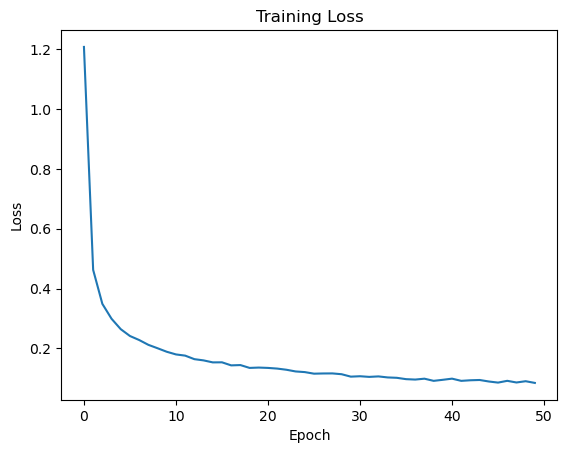

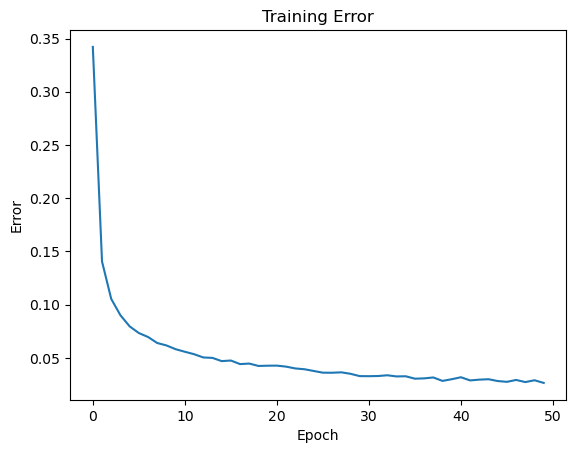

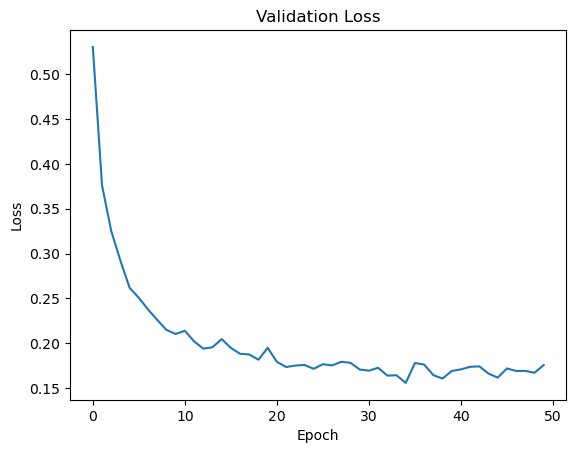

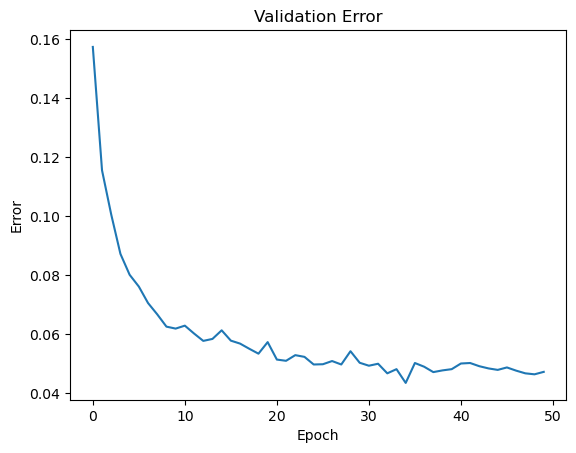

<Figure size 640x480 with 0 Axes>

In [13]:
##########################
########### plot #########
##########################

savepath = "/Users/wli169/Downloads/"
path = os.getcwd() if savepath is None else savepath


def to_plot(data, xlabel, ylabel, title, path):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(path)  # Save the plot
    plt.show()  # Display the plot
    plt.clf()  # Clear the plot for the next plot


to_plot(
    training_losses,
    "Epoch",
    "Loss",
    "Training Loss",
    os.path.join(path, "train_loss.png"),
)

to_plot(
    training_errors,
    "Epoch",
    "Error",
    "Training Error",
    os.path.join(path, "train_error.png"),
)

to_plot(
    validation_losses,
    "Epoch",
    "Loss",
    "Validation Loss",
    os.path.join(path, "val_loss.png"),
)

to_plot(
    validation_errors,
    "Epoch",
    "Error",
    "Validation Error",
    os.path.join(path, "val_error.png"),
)